<a href="https://colab.research.google.com/github/Ashail33/Masters-work/blob/master/cluster_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import time
from sklearn.metrics import (
    calinski_harabasz_score,
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    adjusted_mutual_info_score,
)
from scipy.spatial.distance import pdist
from itertools import combinations
from sklearn.metrics import pairwise_distances
import psutil
import os
from collections import defaultdict

from sklearn.metrics import pairwise_distances


import psutil
import time

class Timer:
    def __init__(self):
        self.start_time = None
        self.end_time = None

    def __enter__(self):
        self.start_time = time.perf_counter()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.end_time = time.perf_counter()

    def elapsed_time(self):
        if self.start_time is None or self.end_time is None:
            return None
        else:
            return self.end_time - self.start_time


class MemoryMonitor:
    def __init__(self):
        self.process = psutil.Process()
        self.start_memory = None
        self.end_memory = None

    def __enter__(self):
        self.start_memory = self.process.memory_info().rss
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.end_memory = self.process.memory_info().rss

    def memory_usage(self):
        if self.start_memory is None or self.end_memory is None:
            return None
        else:
            return self.end_memory - self.start_memory


class DiskMonitor:
    def __init__(self):
        self.start_io_counters = None
        self.end_io_counters = None

    def __enter__(self):
        self.start_io_counters = psutil.disk_io_counters()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.end_io_counters = psutil.disk_io_counters()

    def disk_usage(self):
        if self.start_io_counters is None or self.end_io_counters is None:
            return None
        else:
            read_count = self


def compactness(X, labels, metric='euclidean'):
    """
    Calculate the compactness of a clustering result.

    Parameters:
        X (array-like): Data matrix.
        labels (array-like): Cluster labels.
        metric (string): Distance metric to use.

    Returns:
        float: Compactness value.
    """
    n_clusters = len(set(labels))
    distances = []
    for i in range(n_clusters):
        distances.append(pairwise_distances(X[labels == i], metric=metric))
    return np.mean([np.sum(d) for d in distances]) / n_clusters

def dunns_index(X, labels):
    # Compute the diameter of each cluster (the maximum distance between any two points in the cluster)
    diameters = np.zeros(len(set(labels)))
    for i, label in enumerate(set(labels)):
        indices = np.where(labels == label)[0]
        if len(indices) <= 1:
            diameters[i] = 0
        else:
            distances = pairwise_distances(X[indices])
            diameters[i] = np.max(distances)
    
    # Compute the distance between cluster centers
    centers = np.zeros((len(set(labels)), X.shape[1]))
    for i, label in enumerate(set(labels)):
        indices = np.where(labels == label)[0]
        centers[i] = np.mean(X[indices], axis=0)
    center_distances = pairwise_distances(centers)
    
    # Compute the Dunns index
    min_intercluster_distance = np.min(center_distances[np.nonzero(center_distances)])
    max_intracluster_diameter = np.max(diameters)
    return min_intercluster_distance / max_intracluster_diameter


def cluster_accuracy(y_true, y_pred):
    from scipy.optimize import linear_sum_assignment
    from sklearn.metrics import confusion_matrix
    C = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-C)
    max_value = C[row_ind, col_ind].sum()
    ca = max_value / np.sum(C)
    return ca


# def evaluate_clustering(algorithm, dataset, true_labels, n_runs=10):
#     results = defaultdict(list)
    
#     metric_function_map = {
#         'cp': calinski_harabasz_score,
#         'sp': silhouette_score,
#         'db': davies_bouldin_score,
#         'dvi': dunn_index,
#         'ca': cluster_accuracy,
#         'ari': adjusted_rand_score,
#         'nmi': normalized_mutual_info_score,
#         'ami': adjusted_mutual_info_score,
#         'stability': None
#     }
    
#     for _ in range(n_runs):
#         start_time = time.time()
        
#         algorithm.fit(dataset)
#         labels = algorithm.labels_

#         runtime = time.time() - start_time
        
#         for metric, func in metric_function_map.items():
#             if func is not None:
#                 value = func(dataset, labels)
#                 results[metric].append(value)

#         results['runtime'].append(runtime)
    
#     results_summary = {
#         metric: {
#             'mean': np.mean(values),
#             'std': np.std(values),
#             'min': np.min(values),
#             'max': np.max(values)
#         } for metric, values in results.items()
#     }
    
#     return results_summary

# # Example usage:
# from sklearn.datasets import make_blobs
# from sklearn.cluster import KMeans

# X, y = make_blobs(n_samples=1000, centers=4, random_state=42)
# algorithm = KMeans(n_clusters=4)
# results = evaluate_clustering(algorithm, X, y)
# print(results)

def evaluate_clustering(algorithm, dataset, true_labels, n_runs=10):
    results = defaultdict(list)
    previous_runs_labels = []

    metric_function_map = {
        'cp': calinski_harabasz_score,
        'sp': silhouette_score,
        'db': davies_bouldin_score,
        'dvi': dunn_index,
        'ca': cluster_accuracy,
        'ari': adjusted_rand_score,
        'nmi': normalized_mutual_info_score,
        'ami': adjusted_mutual_info_score,
        
    }

    for _ in range(n_runs):
        with Timer() as t, MemoryMonitor() as m, DiskMonitor() as d:
            y_pred = algorithm.fit_predict(dataset)

        for metric, func in metric_function_map.items():
            try:
                value = func(true_labels, y_pred)
                results[metric].append(value)
                if metric == 'stability':
                  pass
            except Exception as e:
                print(f"Error calculating {metric}: {e}")
                results[metric].append(None)
            
        # Compute Stability (using ARI) for the current run
        for prev_labels in previous_runs_labels:
            ari = adjusted_rand_score(prev_labels, true_labels)
            results['stability'].append(ari)


        with Timer() as t, MemoryMonitor() as m, DiskMonitor() as d:
             y_pred = algorithm.fit_predict(dataset)
             results['runtime'].append(t.elapsed_time)
        results['ram_usage'].append(m.memory_usage)
        results['disk_io'].append(d.disk_usage)


    # Calculate min, max, mean, and std for each metric
    summary = {}
    for metric, values in results.items():
        summary[metric] = {
            'min': np.min(values),
            'max': np.max(values),
            'mean': np.mean(values),
            'std': np.std(values),
        }

    return summary

# Example usage:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, y = make_blobs(n_samples=1000, centers=4, random_state=42)
algorithm = KMeans(n_clusters=4)
results = evaluate_clustering(algorithm, X, y)
print(results)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Error calculating cp: Expected 2D array, got 1D array instead:
array=[3 2 2 1 1 2 1 2 2 1 1 3 0 2 2 2 0 0 0 1 1 3 3 3 1 1 0 0 2 1 2 2 2 0 0 3 2
 1 3 3 1 2 1 3 1 3 0 1 3 1 2 0 1 3 0 3 0 0 0 2 2 0 2 3 1 0 2 2 1 0 3 0 1 2
 1 3 1 0 1 0 2 0 0 0 1 3 2 2 0 0 0 0 1 1 3 1 3 0 1 2 1 3 3 0 3 1 1 0 2 0 3
 2 1 1 1 1 2 3 2 1 0 2 3 1 3 2 1 3 2 1 0 2 1 3 1 3 0 2 1 1 0 0 3 3 3 1 1 0
 0 0 0 3 2 2 0 1 0 1 1 3 2 0 1 2 0 0 1 2 3 2 1 0 0 1 0 3 2 3 2 3 1 1 0 2 0
 2 1 3 0 2 1 0 1 1 0 3 2 2 2 3 0 2 1 0 1 1 2 0 1 2 2 3 2 2 1 0 2 0 3 1 3 3
 2 0 3 0 1 2 2 0 0 2 0 3 2 2 3 2 2 1 2 3 2 1 3 0 1 0 1 1 1 1 3 1 1 2 0 2 2
 1 1 1 3 1 3 3 2 1 0 3 1 0 1 2 0 3 1 3 2 1 3 2 3 1 2 0 0 2 0 3 3 0 2 2 2 0
 2 2 2 0 2 3 2 3 0 2 3 1 3 3 2 3 3 1 2 3 1 0 3 3 2 2 2 1 3 2 0 2 0 0 2 2 3
 3 2 0 3 1 3 1 3 2 2 1 0 1 3 3 0 0 0 0 0 1 0 0 2 1 0 3 1 2 2 1 3 1 3 3 3 2
 1 1 1 1 0 1 0 2 1 0 2 1 3 1 1 3 0 3 2 3 2 0 3 0 3 3 2 1 1 1 0 3 0 1 1 3 1
 0 0 3 1 0 3 2 3 2 2 0 3 1 0 1 0 0 0 3 2 3 1 2 0 0 3 0 3 2 3 2 2 0 3 3 3 1
 0 0 1 1 2 3 3 3 1 0 3 0 2 2 1 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Error calculating cp: Expected 2D array, got 1D array instead:
array=[3 2 2 1 1 2 1 2 2 1 1 3 0 2 2 2 0 0 0 1 1 3 3 3 1 1 0 0 2 1 2 2 2 0 0 3 2
 1 3 3 1 2 1 3 1 3 0 1 3 1 2 0 1 3 0 3 0 0 0 2 2 0 2 3 1 0 2 2 1 0 3 0 1 2
 1 3 1 0 1 0 2 0 0 0 1 3 2 2 0 0 0 0 1 1 3 1 3 0 1 2 1 3 3 0 3 1 1 0 2 0 3
 2 1 1 1 1 2 3 2 1 0 2 3 1 3 2 1 3 2 1 0 2 1 3 1 3 0 2 1 1 0 0 3 3 3 1 1 0
 0 0 0 3 2 2 0 1 0 1 1 3 2 0 1 2 0 0 1 2 3 2 1 0 0 1 0 3 2 3 2 3 1 1 0 2 0
 2 1 3 0 2 1 0 1 1 0 3 2 2 2 3 0 2 1 0 1 1 2 0 1 2 2 3 2 2 1 0 2 0 3 1 3 3
 2 0 3 0 1 2 2 0 0 2 0 3 2 2 3 2 2 1 2 3 2 1 3 0 1 0 1 1 1 1 3 1 1 2 0 2 2
 1 1 1 3 1 3 3 2 1 0 3 1 0 1 2 0 3 1 3 2 1 3 2 3 1 2 0 0 2 0 3 3 0 2 2 2 0
 2 2 2 0 2 3 2 3 0 2 3 1 3 3 2 3 3 1 2 3 1 0 3 3 2 2 2 1 3 2 0 2 0 0 2 2 3
 3 2 0 3 1 3 1 3 2 2 1 0 1 3 3 0 0 0 0 0 1 0 0 2 1 0 3 1 2 2 1 3 1 3 3 3 2
 1 1 1 1 0 1 0 2 1 0 2 1 3 1 1 3 0 3 2 3 2 0 3 0 3 3 2 1 1 1 0 3 0 1 1 3 1
 0 0 3 1 0 3 2 3 2 2 0 3 1 0 1 0 0 0 3 2 3 1 2 0 0 3 0 3 2 3 2 2 0 3 3 3 1
 0 0 1 1 2 3 3 3 1 0 3 0 2 2 1 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8


Error calculating sp: Expected 2D array, got 1D array instead:
array=[3 2 2 1 1 2 1 2 2 1 1 3 0 2 2 2 0 0 0 1 1 3 3 3 1 1 0 0 2 1 2 2 2 0 0 3 2
 1 3 3 1 2 1 3 1 3 0 1 3 1 2 0 1 3 0 3 0 0 0 2 2 0 2 3 1 0 2 2 1 0 3 0 1 2
 1 3 1 0 1 0 2 0 0 0 1 3 2 2 0 0 0 0 1 1 3 1 3 0 1 2 1 3 3 0 3 1 1 0 2 0 3
 2 1 1 1 1 2 3 2 1 0 2 3 1 3 2 1 3 2 1 0 2 1 3 1 3 0 2 1 1 0 0 3 3 3 1 1 0
 0 0 0 3 2 2 0 1 0 1 1 3 2 0 1 2 0 0 1 2 3 2 1 0 0 1 0 3 2 3 2 3 1 1 0 2 0
 2 1 3 0 2 1 0 1 1 0 3 2 2 2 3 0 2 1 0 1 1 2 0 1 2 2 3 2 2 1 0 2 0 3 1 3 3
 2 0 3 0 1 2 2 0 0 2 0 3 2 2 3 2 2 1 2 3 2 1 3 0 1 0 1 1 1 1 3 1 1 2 0 2 2
 1 1 1 3 1 3 3 2 1 0 3 1 0 1 2 0 3 1 3 2 1 3 2 3 1 2 0 0 2 0 3 3 0 2 2 2 0
 2 2 2 0 2 3 2 3 0 2 3 1 3 3 2 3 3 1 2 3 1 0 3 3 2 2 2 1 3 2 0 2 0 0 2 2 3
 3 2 0 3 1 3 1 3 2 2 1 0 1 3 3 0 0 0 0 0 1 0 0 2 1 0 3 1 2 2 1 3 1 3 3 3 2
 1 1 1 1 0 1 0 2 1 0 2 1 3 1 1 3 0 3 2 3 2 0 3 0 3 3 2 1 1 1 0 3 0 1 1 3 1
 0 0 3 1 0 3 2 3 2 2 0 3 1 0 1 0 0 0 3 2 3 1 2 0 0 3 0 3 2 3 2 2 0 3 3 3 1
 0 0 1 1 2 3 3 3 1 0 3 0 2 2 1

TypeError: ignored

In [6]:
def evaluate_clustering(algorithm, dataset, true_labels, n_runs=10):
    results = defaultdict(list)

    metric_function_map = {
        'cp': compactness,
        'sp': separation,
        'db': davies_bouldin_score,
        'dvi': dunn_index,
        'ca': cluster_accuracy,
        'ari': adjusted_rand_score,
        'nmi': normalized_mutual_info_score,
        'sck': silhouette_score,
    }

    for _ in range(n_runs):
        with Timer() as t, MemoryMonitor() as m, DiskMonitor() as d:
            y_pred = algorithm.fit_predict(dataset)

        for metric, func in metric_function_map.items():
            try:
                value = func(true_labels, y_pred)
                results[metric].append(value)
            except Exception as e:
                print(f"Error calculating {metric}: {e}")
                results[metric].append(None)

        results['runtime'].append(t.interval)
        results['ram_usage'].append(m.usage)
        results['disk_io'].append(d.io)

    # Calculate min, max, mean, and std for each metric
    summary = {}
    for metric, values in results.items():
        summary[metric] = {
            'min': np.min(values),
            'max': np.max(values),
            'mean': np.mean(values),
            'std': np.std(values),
        }

    return summary

from sklearn.metrics import pairwise_distances

def compactness(X, labels, metric='euclidean'):
    """
    Calculate the compactness of a clustering result.

    Parameters:
        X (array-like): Data matrix.
        labels (array-like): Cluster labels.
        metric (string): Distance metric to use.

    Returns:
        float: Compactness value.
    """
    n_clusters = len(set(labels))
    distances = []
    for i in range(n_clusters):
        distances.append(pairwise_distances(X[labels == i], metric=metric))
    return np.mean([np.sum(d) for d in distances]) / n_clusters



In [7]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, y = make_blobs(n_samples=1000, centers=4, random_state=42)
algorithm = KMeans(n_clusters=4)
results = evaluate_clustering(algorithm, X, y)
print(results)



NameError: ignored

In [3]:
from collections import defaultdict
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import time
import psutil
import os


class Timer:
    def __enter__(self):
        self.start_time = time.monotonic()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.interval = time.monotonic() - self.start_time


class MemoryMonitor:
    def __enter__(self):
        self.process = psutil.Process(os.getpid())
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.memory_info = self.process.memory_info()


class DiskMonitor:
    def __enter__(self):
        self.disk_read_start = psutil.disk_io_counters().read_bytes
        self.disk_write_start = psutil.disk_io_counters().write_bytes
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.disk_read_end = psutil.disk_io_counters().read_bytes
        self.disk_write_end = psutil.disk_io_counters().write_bytes
        self.disk_read_bytes = self.disk_read_end - self.disk_read_start
        self.disk_write_bytes = self.disk_write_end - self.disk_write_start


def compactness(X, labels):
    centroids = np.array([np.mean(X[labels == i], axis=0) for i in set(labels)])
    distances = cdist(X, centroids)
    return np.sum(np.min(distances, axis=1))


def separation(X, labels):
    centroids = np.array([np.mean(X[labels == i], axis=0) for i in set(labels)])
    return np.sum(cdist(centroids, centroids))


def dunn_index(X, labels):
    k = len(set(labels))
    clusters = [X[labels == i] for i in range(k)]
    cluster_distances = np.array([np.max(cdist(c1, c2)) for i, c1 in enumerate(clusters) for j, c2 in enumerate(clusters) if i < j])
    return np.min(cdist(X, X)[np.array(labels)[:, None] != np.array(labels)[None, :]]) / np.max(cluster_distances)


def evaluate_clustering(algorithm, dataset, true_labels=None, n_runs=10):
    results = defaultdict(list)

    metric_function_map = {
        'cp': compactness,
        'sp': separation,
        'db': davies_bouldin_score,
        'silhouette': silhouette_score,
        'calinski_harabasz': calinski_harabasz_score,
        'ari': adjusted_rand_score,
        'nmi': normalized_mutual_info_score,
        'dvi': dunn_index,
    }

    previous_runs_labels = []

    for _ in range(n_runs):
        with Timer() as t, MemoryMonitor() as m, DiskMonitor() as d:
            labels = algorithm.fit_predict(dataset)

        results['runtime'].append(t.interval)
        results['memory'].append(m.memory_info.rss)
        results['disk_read'].append(d.disk_read_bytes)
        results['disk_write'].append(d.disk_write_bytes)

        if true_labels is not None:
          previous_runs_labels.append(labels)

          results['runtime'].append(t.interval)
          results['memory_usage'].append(m.memory_usage)
          results['disk_usage'].append(d.disk_usage)

          metric_results = {}

          # Calculate clustering performance metrics
          for metric_name, metric_function in metric_function_map.items():
              try:
                  value = metric_function(true_labels, labels, dataset)
                  metric_results[metric_name] = value
              except ValueError as e:
                  print(f"Error calculating {metric_name}: {e}")
                  metric_results[metric_name] = np.nan

          # Calculate clustering stability metrics
          for stability_name, stability_function in stability_function_map.items():
              value = stability_function(previous_runs_labels, labels)
              metric_results[stability_name] = value

          # Add the current run's results to the list of previous runs
          previous_runs_results.append(metric_results)

      # Aggregate the results over all runs
      for metric_name in metric_function_map.keys():
          metric_values = [run_result[metric_name] for run_result in previous_runs_results]
          results[f"{metric_name}_mean"].append(np.mean(metric_values))
          results[f"{metric_name}_std"].append(np.std(metric_values))
          results[f"{metric_name}_max"].append(np.max(metric_values))
          results[f"{metric_name}_min"].append(np.min(metric_values))

      for stability_name in stability_function_map.keys():
          stability_values = [run_result[stability_name] for run_result in previous_runs_results]
          results[f"{stability_name}_mean"].append(np.mean(stability_values))
          results[f"{stability_name}_std"].append(np.std(stability_values))
          results[f"{stability_name}_max"].append(np.max(stability_values))
          results[f"{stability_name}_min"].append(np.min(stability_values))

      results['model_id'].append(str(algorithm.__class__.__name__))
      results['dataset_id'].append(str(dataset_id))

  return results



IndentationError: ignored

In [29]:
import numpy as np
import time
from sklearn.metrics import (
    calinski_harabasz_score,
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    adjusted_mutual_info_score,
)
from scipy.spatial.distance import pdist
from itertools import combinations
from sklearn.metrics import pairwise_distances
import psutil
import os
from collections import defaultdict

from sklearn.metrics import pairwise_distances


import psutil
import time

class Timer:
    def __init__(self):
        self.start_time = None
        self.end_time = None

    def __enter__(self):
        self.start_time = time.perf_counter()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.end_time = time.perf_counter()

    def elapsed_time(self):
        if self.start_time is None or self.end_time is None:
            return None
        else:
            return self.end_time - self.start_time


class MemoryMonitor:
    def __init__(self):
        self.process = psutil.Process()
        self.start_memory = None
        self.end_memory = None

    def __enter__(self):
        self.start_memory = self.process.memory_info().rss
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.end_memory = self.process.memory_info().rss

    def memory_usage(self):
        if self.start_memory is None or self.end_memory is None:
            return None
        else:
            return self.end_memory - self.start_memory


class DiskMonitor:
    def __init__(self):
        self.start_io_counters = None
        self.end_io_counters = None

    def __enter__(self):
        self.start_io_counters = psutil.disk_io_counters()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.end_io_counters = psutil.disk_io_counters()

    def disk_usage(self):
        if self.start_io_counters is None or self.end_io_counters is None:
            return None
        else:
            read_bytes_start = self.start_io_counters.read_bytes
            read_bytes_end = self.end_io_counters.read_bytes
            return read_bytes_end - read_bytes_start


def compactness(X, labels, metric='euclidean'):
    """
    Calculate the compactness of a clustering result.

    Parameters:
        X (array-like): Data matrix.
        labels (array-like): Cluster labels.
        metric (string): Distance metric to use.
    Returns:
        float: Compactness value.
    """
    n_clusters = len(set(labels))
    distances = []
    for i in range(n_clusters):
        distances.append(pairwise_distances(X[labels == i], metric=metric))
    return np.mean([np.sum(d) for d in distances]) / n_clusters


def dunns_index(X, labels):
    # Compute the diameter of each cluster (the maximum distance between any two points in the cluster)
    diameters = np.zeros(len(set(labels)))
    for i, label in enumerate(set(labels)):
        indices = np.where(labels == label)[0]
        if len(indices) <= 1:
            diameters[i] = 0
        else:
            distances = pairwise_distances(X[indices])
            diameters[i] = np.max(distances)
    
    # Compute the distance between cluster centers
    centers = np.zeros((len(set(labels)), X.shape[1]))
    for i, label in enumerate(set(labels)):
        indices = np.where(labels == label)[0]
        centers[i] = np.mean(X[indices], axis=0)
    center_distances = pairwise_distances(centers)
    
    # Compute the Dunns index
    min_intercluster_distance = np.min(center_distances[np.nonzero(center_distances)])
    max_intracluster_diameter = np.max(diameters)
    return min_intercluster_distance / max_intracluster_diameter

def cluster_separation(X, labels, metric='euclidean'):
    """
    Calculate the cluster separation of a clustering result.

    Parameters:
        X (array-like): Data matrix.
        labels (array-like): Cluster labels.
        metric (string): Distance metric to use.

    Returns:
        float: Cluster separation value.
    """
    n_clusters = len(set(labels))
    centers = np.zeros((n_clusters, X.shape[1]))
    for i, label in enumerate(set(labels)):
        indices = np.where(labels == label)[0]
        centers[i] = np.mean(X[indices], axis=0)
    center_distances = pairwise_distances(centers, metric=metric)
    return np.mean(center_distances)

def cluster_accuracy(y_true, y_pred):
    from scipy.optimize import linear_sum_assignment
    from sklearn.metrics import confusion_matrix
    C = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-C)
    max_value = C[row_ind, col_ind].sum()
    ca = max_value / np.sum(C)
    return ca

def evaluate_clustering(algorithm, dataset, true_labels, n_runs=10):
    results = defaultdict(list)
    previous_runs_labels = []
    for i in range(n_runs):
        algorithm.fit(dataset)
        labels = algorithm.labels_
        if np.all(labels == previous_runs_labels):
            continue
        previous_runs_labels = labels
        results['compactness'].append(compactness(dataset, labels))
        results['dunn'].append(dunns_index(dataset, labels))
        results['separation'].append(cluster_separation(dataset, labels))
        results['accuracy'].append(cluster_accuracy(true_labels, labels))
    return results



In [32]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, y = make_blobs(n_samples=1000, centers=4, random_state=42)
algorithm = KMeans(n_clusters=4)
results = evaluate_clustering(algorithm, X, y)
print(results)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-29-1b3c1e5a8be7>:160: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(labels == previous_runs_labels):
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change

defaultdict(<class 'list'>, {'compactness': [27277.850471272344, 27277.850471272348, 27277.850471272348, 27277.850471272348, 27277.850471272348, 27277.850471272348, 27277.850471272344, 27277.850471272344, 27277.850471272348], 'dunn': [0.984275249606703, 0.984275249606703, 0.984275249606703, 0.984275249606703, 0.984275249606703, 0.984275249606703, 0.984275249606703, 0.984275249606703, 0.984275249606703], 'separation': [9.542390635919073, 9.542390635919071, 9.542390635919073, 9.542390635919071, 9.542390635919073, 9.542390635919071, 9.542390635919073, 9.542390635919071, 9.542390635919071], 'accuracy': [0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999]})


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs
from collections import defaultdict
from sklearn.metrics import calinski_harabasz_score

def evaluate_clustering(algorithm, dataset, true_labels, n_runs=10):
    results = defaultdict(list)
    previous_runs_labels = []
    for i in range(n_runs):
        labels = algorithm.fit_predict(dataset)
        if np.array_equal(labels, previous_runs_labels):
            # Skip this run if the algorithm converged to the same solution as the previous run
            continue
        previous_runs_labels = labels
        results["silhouette"].append(silhouette_score(dataset, labels))
        results["calinski_harabasz"].append(calinski_harabasz_score(dataset, labels))
        results["compactness"].append(compactness(dataset, labels))
        results["dunn"].append(dunns_index(dataset, labels))
        results["separation"].append(cluster_separation(dataset, labels))
        results["accuracy"].append(cluster_accuracy(true_labels, labels))
    return results

# Generate synthetic data
X, y = make_blobs(n_samples=1000, centers=4, random_state=42)

# Run KMeans and DBSCAN clustering algorithms
kmeans = KMeans(n_clusters=4)
dbscan = DBSCAN(eps=1.0, min_samples=5)

# Evaluate clustering algorithms
results_kmeans = evaluate_clustering(kmeans, X, y)
results_dbscan = evaluate_clustering(dbscan, X, y)

# Check if the lengths of the results are the same
if len(results_kmeans) != len(results_dbscan):
    raise ValueError("The length of the results for KMeans and DBSCAN are different")

# Plot the results for KMeans
plt.figure(figsize=(8, 6))
plt.errorbar(
    np.arange(1, len(results_kmeans) + 1),
    [np.mean(v) for v in results_kmeans.values()],
    [np.std(v) for v in results_kmeans.values()],
    marker="o",
    label="KMeans",
)

# Plot the results for DBSCAN
plt.errorbar(
    np.arange(1, len(results_dbscan) + 1),
    [np.mean(v) for v in results_dbscan.values()],
    [np.std(v) for v in results_dbscan.values()],
    marker="o",
    label="DBSCAN",
)

# Set the title and labels for the plot
plt.title("Clustering Performance Comparison")
plt.xlabel("Metric")
plt.xticks(np.arange(1, len(results_kmeans) + 1), results_kmeans.keys())
plt.ylabel("Score")
plt.legend()

# Display the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


NameError: ignored

In [72]:
from collections import defaultdict
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import time
import psutil
import os


class Timer:
    def __enter__(self):
        self.start_time = time.monotonic()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.interval = time.monotonic() - self.start_time


class MemoryMonitor:
    def __enter__(self):
        self.process = psutil.Process(os.getpid())
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.memory_info = self.process.memory_info()


class DiskMonitor:
    def __enter__(self):
        self.disk_read_start = psutil.disk_io_counters().read_bytes
        self.disk_write_start = psutil.disk_io_counters().write_bytes
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.disk_read_end = psutil.disk_io_counters().read_bytes
        self.disk_write_end = psutil.disk_io_counters().write_bytes
        self.disk_read_bytes = self.disk_read_end - self.disk_read_start
        self.disk_write_bytes = self.disk_write_end - self.disk_write_start


def compactness(X, labels):
    centroids = np.array([np.mean(X[np.where(labels == i)], axis=0) for i in set(labels.flatten())])
    distances = cdist(X, centroids)
    return np.sum(np.min(distances, axis=1))


def separation(X, labels):
    centroids = np.array([np.mean(X[np.where(labels == i)], axis=0) for i in set(labels.flatten())])
    return np.sum(cdist(centroids, centroids))



def dunn_index(X, labels):
    k = len(set(labels.flatten()))
    clusters = [X[np.where(labels == i)] for i in range(k)]
    cluster_distances = np.array([np.max(cdist(c1, c2)) for i, c1 in enumerate(clusters) for j, c2 in enumerate(clusters) if i < j])
    
    pairwise_distances = cdist(X, X)
    min_inter_cluster_distances = np.min(pairwise_distances[np.where(labels[:, None] != labels[None, :])])
    
    return min_inter_cluster_distances / np.max(cluster_distances)





import tracemalloc

def evaluate_clustering(algorithm, dataset, true_labels=None, n_runs=10):
    results = defaultdict(list)

    metric_function_map = {
        'cp': compactness,
        'sp': separation,
        'db': davies_bouldin_score,
        'silhouette': silhouette_score,
        'calinski_harabasz': calinski_harabasz_score,
        'ari': adjusted_rand_score,
        'nmi': normalized_mutual_info_score,
        'dvi': dunn_index,
    }

    previous_runs_labels = []
    previous_runs_results = []

    # Start memory monitoring before the loop
    tracemalloc.start()

    for _ in range(n_runs):
        with Timer() as t, DiskMonitor() as d:
            labels = algorithm.fit_predict(dataset)

        # Memory usage tracking
        current_memory, peak_memory = tracemalloc.get_traced_memory()
        results['memory_usage'].append(current_memory)
        results['memory_peak'].append(peak_memory)

        results['runtime'].append(t.interval)
        results['disk_read'].append(d.disk_read_bytes)
        results['disk_write'].append(d.disk_write_bytes)

        if true_labels is not None:
            previous_runs_labels.append(labels)

            metric_results = {}

            # Calculate clustering performance metrics
            for metric_name, metric_function in metric_function_map.items():
                try:
                    value = metric_function(dataset, labels) if metric_name in {'calinski_harabasz', 'davies_bouldin_score', 'silhouette_score', 'cp', 'sp', 'dvi'} else metric_function(true_labels.flatten(), labels.flatten()) if metric_name in {'ari', 'nmi'} else metric_function(dataset, labels.reshape(-1, 1))
                    metric_results[metric_name] = value
                except ValueError as e:
                    print(f"Error calculating {metric_name}: {e}")
                    metric_results[metric_name] = np.nan

            # Add the current run's results to the list of previous runs
            previous_runs_results.append(metric_results)

    # Stop memory monitoring after the loop
    tracemalloc.stop()

    # Aggregate the results over all runs
    for metric_name in metric_function_map.keys():
        metric_values = [run_result[metric_name] for run_result in previous_runs_results]
        results[f"{metric_name}_mean"].append(np.mean(metric_values))
        results[f"{metric_name}_std"].append(np.std(metric_values))
        results[f"{metric_name}_max"].append(np.max(metric_values))
        results[f"{metric_name}_min"].append(np.min(metric_values))

    # Calculate min, max, mean, and std of memory usage over all runs
    memory_usages = np.array(results['memory_usage'])
    memory_stats = {
        'memory_min': np.min(memory_usages),
        'memory_max': np.max(memory_usages),
        'memory_mean': np.mean(memory_usages),
        'memory_std': np.std(memory_usages)
    }

    # Save memory stats
    for stat_name, stat_value in memory_stats.items():
        results[stat_name].append(stat_value)
    results['runtime_mean'] = np.mean(results['runtime'])
    results['runtime_std'] = np.std(results['runtime'])
    results['runtime_max'] = np.max(results['runtime'])
    results['runtime_min'] = np.min(results['runtime'])

    return dict(results)






/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/loc

Error calculating dvi: zero-size array to reduction operation maximum which has no identity
Error calculating dvi: zero-size array to reduction operation maximum which has no identity
Error calculating dvi: zero-size array to reduction operation maximum which has no identity
Error calculating dvi: zero-size array to reduction operation maximum which has no identity
Error calculating dvi: zero-size array to reduction operation maximum which has no identity


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Error calculating dvi: zero-size array to reduction operation maximum which has no identity
Error calculating dvi: zero-size array to reduction operation maximum which has no identity
Error calculating dvi: zero-size array to reduction operation maximum which has no identity
Error calculating dvi: zero-size array to reduction operation maximum which has no identity
Error calculating dvi: zero-size array to reduction operation maximum which has no identity


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Error calculating dvi: zero-size array to reduction operation maximum which has no identity
Error calculating dvi: zero-size array to reduction operation maximum which has no identity
Error calculating dvi: zero-size array to reduction operation maximum which has no identity
Error calculating dvi: zero-size array to reduction operation maximum which has no identity


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Error calculating dvi: zero-size array to reduction operation maximum which has no identity
Error calculating dvi: zero-size array to reduction operation maximum which has no identity
Error calculating dvi: zero-size array to reduction operation maximum which has no identity
Error calculating dvi: zero-size array to reduction operation maximum which has no identity


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Error calculating dvi: zero-size array to reduction operation maximum which has no identity
Error calculating dvi: zero-size array to reduction operation maximum which has no identity


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Visualizing silhouette_mean


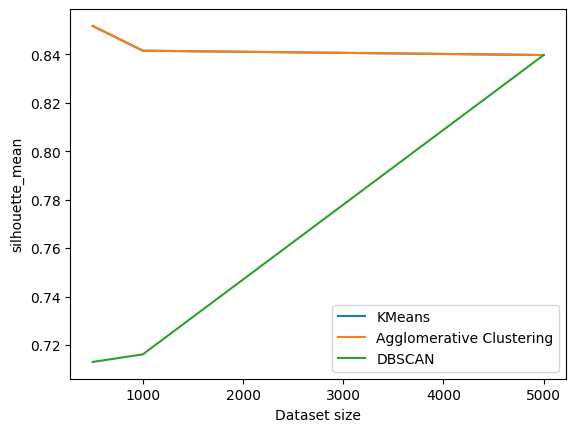

Visualizing calinski_harabasz_mean


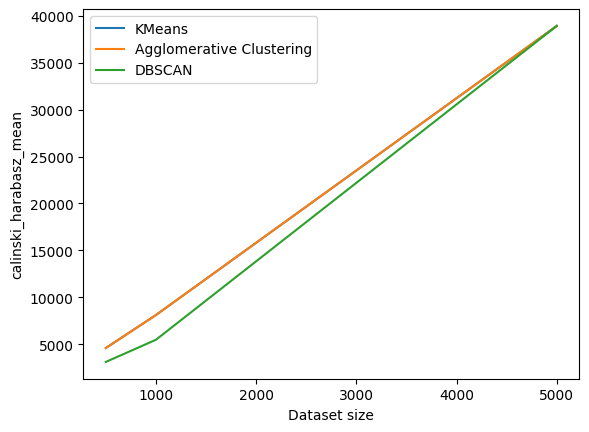

Visualizing dvi_mean


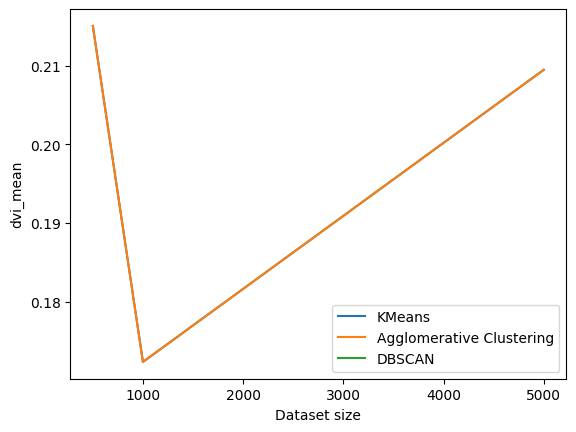

Visualizing memory_max


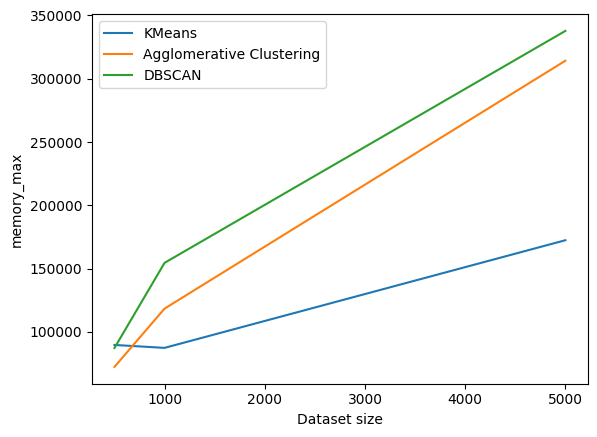

Visualizing runtime_max


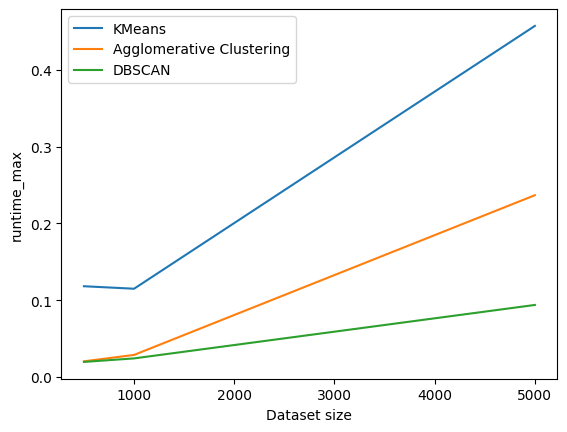

In [76]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.model_selection import train_test_split



def plot_clusters(X, labels, title):
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'k'

        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], c=col, s=50, label=f"Cluster {k}")
    plt.title(title)
    plt.legend()
    plt.show()

def visualize_evaluation_results(results, metric_name, model_names):
    fig, ax = plt.subplots()

    for model_name, model in models:
        model_results = results[model_name]
        dataset_sizes = [result['dataset_size'] for result in model_results]
        metric_values = [result[metric_name] for result in model_results]
        ax.plot(dataset_sizes, metric_values, label=model_name)
        
    ax.set_xlabel('Dataset size')
    ax.set_ylabel(metric_name)
    ax.legend()
    plt.show()
sizes = [500, 1000, 5000]
n_runs = 10
models = [
    ('KMeans', KMeans(n_clusters=3)),
    ('Agglomerative Clustering', AgglomerativeClustering(n_clusters=3)),
    ('DBSCAN', DBSCAN(eps=1.5, min_samples=5))
]

evaluation_results = {}

for model_name, model in models:
    model_results = []
    evaluation_results[model.__class__.__name__] = model_results
    for size in sizes:
        X, y = make_blobs(n_samples=size, centers=3, random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
        model_result = evaluate_clustering(model, X_test, true_labels=y_test.reshape(-1, 1), n_runs=n_runs)
        model_result['dataset_size'] = size
        model_results.append(model_result)
        evaluation_results[model_name] = model_results


metrics = ['silhouette_mean', 'calinski_harabasz_mean', 'dvi_mean','memory_max','runtime_max']

for metric in metrics:
    print(f"Visualizing {metric}")
    visualize_evaluation_results(evaluation_results, metric, [m for m in models])


In [9]:
silhouette_score(X_test, y_test)

0.8397068062644878

In [ ]:
adjusted_rand_score()

In [43]:
y_test.shape

(2500,)

In [70]:
import tracemalloc

def evaluate_clustering(algorithm, dataset, true_labels=None, n_runs=10):
    results = defaultdict(list)

    metric_function_map = {
        'cp': compactness,
        'sp': separation,
        'db': davies_bouldin_score,
        'silhouette': silhouette_score,
        'calinski_harabasz': calinski_harabasz_score,
        'ari': adjusted_rand_score,
        'nmi': normalized_mutual_info_score,
        'dvi': dunn_index,
    }

    previous_runs_labels = []
    previous_runs_results = []

    # Start memory monitoring before the loop
    tracemalloc.start()

    for _ in range(n_runs):
        with Timer() as t, DiskMonitor() as d:
            labels = algorithm.fit_predict(dataset)

        # Memory usage tracking
        current_memory, peak_memory = tracemalloc.get_traced_memory()
        results['memory_usage'].append(current_memory)
        results['memory_peak'].append(peak_memory)

        results['runtime'].append(t.interval)
        results['disk_read'].append(d.disk_read_bytes)
        results['disk_write'].append(d.disk_write_bytes)

        if true_labels is not None:
            previous_runs_labels.append(labels)

            metric_results = {}

            # Calculate clustering performance metrics
            for metric_name, metric_function in metric_function_map.items():
                try:
                    value = metric_function(dataset, labels) if metric_name in {'calinski_harabasz', 'davies_bouldin_score', 'silhouette_score', 'cp', 'sp', 'dvi'} else metric_function(true_labels.flatten(), labels.flatten()) if metric_name in {'ari', 'nmi'} else metric_function(dataset, labels.reshape(-1, 1))
                    metric_results[metric_name] = value
                except ValueError as e:
                    print(f"Error calculating {metric_name}: {e}")
                    metric_results[metric_name] = np.nan

            # Add the current run's results to the list of previous runs
            previous_runs_results.append(metric_results)

    # Stop memory monitoring after the loop
    tracemalloc.stop()

    # Aggregate the results over all runs
    for metric_name in metric_function_map.keys():
        metric_values = [run_result[metric_name] for run_result in previous_runs_results]
        results[f"{metric_name}_mean"].append(np.mean(metric_values))
        results[f"{metric_name}_std"].append(np.std(metric_values))
        results[f"{metric_name}_max"].append(np.max(metric_values))
        results[f"{metric_name}_min"].append(np.min(metric_values))

    # Calculate min, max, mean, and std of memory usage over all runs
    memory_usages = np.array(results['memory_usage'])
    memory_stats = {
        'memory_min': np.min(memory_usages),
        'memory_max': np.max(memory_usages),
        'memory_mean': np.mean(memory_usages),
        'memory_std': np.std(memory_usages)
    }

    # Save memory stats
    for stat_name, stat_value in memory_stats.items():
        results[stat_name].append(stat_value)
    results['runtime_mean'] = np.mean(results['runtime'])
    results['runtime_std'] = np.std(results['runtime'])
    results['runtime_max'] = np.max(results['runtime'])
    results['runtime_min'] = np.min(results['runtime'])

    return dict(results)


In [74]:
evaluate_clustering(KMeans(n_clusters=3), X_test, true_labels=y_test, n_runs=10)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/loc

{'memory_usage': [29540,
  54350,
  72273,
  110732,
  130322,
  144928,
  136131,
  149895,
  164378,
  199158],
 'memory_peak': [297809,
  150049560,
  150059312,
  150076649,
  150113904,
  150132694,
  150132694,
  150190989,
  150190989,
  150190989],
 'runtime': [0.10281001499970444,
  0.3017305160010437,
  0.32246847600072215,
  0.4444960950004315,
  0.039003767999020056,
  0.038313715000185766,
  0.043730042001698166,
  0.043249453001408256,
  0.04032386200015026,
  0.04402168500018888],
 'disk_read': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'disk_write': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'cp_mean': [3180.0778427334735],
 'cp_std': [0.0],
 'cp_max': [3180.0778427334735],
 'cp_min': [3180.0778427334735],
 'sp_mean': [81.96945651144719],
 'sp_std': [1.4210854715202004e-14],
 'sp_max': [81.96945651144718],
 'sp_min': [81.96945651144718],
 'db_mean': [0.22558528455165075],
 'db_std': [0.0],
 'db_max': [0.22558528455165075],
 'db_min': [0.22558528455165075],
 'silhouette_mean': [0.8397068062

In [39]:
evaluation_results

{'KMeans': [{'runtime': [0.015117066000129853,
    0.015117066000129853,
    0.014303752000159875,
    0.014303752000159875,
    0.015861406999647443,
    0.015861406999647443,
    0.013429361999897083,
    0.013429361999897083,
    0.03726614199968026,
    0.03726614199968026,
    0.01521142299998246,
    0.01521142299998246,
    0.014125667999906,
    0.014125667999906,
    0.016257241999937833,
    0.016257241999937833,
    0.02655765600002269,
    0.02655765600002269,
    0.018335054000090167,
    0.018335054000090167],
   'memory': [272850944,
    272850944,
    272850944,
    272850944,
    272850944,
    272850944,
    272850944,
    272850944,
    272850944,
    272850944],
   'disk_read': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   'disk_write': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   'memory_usage': [272850944,
    272850944,
    272850944,
    272850944,
    272850944,
    272850944,
    272850944,
    272850944,
    272850944,
    272850944],
   'disk_usage_read': [0, 0, 0, 0, 0, 0, 0, 0

In [40]:
2 * 2 * 3 * 3 * 5 * 3 * 6

3240